<h2> Análise exploratória dos dados da recuperaçao de Cuiabá e Lamego </h2>
<p> OBJETIVO: Em estatística, a análise exploratória de dados (AED) é uma abordagem à análise de conjuntos de dados de modo a resumir suas características principais, frequentemente com métodos visuais. Um modelo estatístico pode ou não ser usado, mas primariamente a AED tem como objetivo observar o que os dados podem nos dizer além da modelagem formal ou do processo de teste de hipóteses. </p>

<ol>
   <li> Responsável: David Alvarenga Drumond </li> 
   <li> Data: 11/05/2020 </li> 
   <li> Belo horizonte, Minas Gerais, Brasil </li> 
</ol>

<p> SUMÁRIO  </p>
<p> ............................................................................................... </p>
<ol>  
    <li> 1 - Importação de bibliotecas e dados </li>
    <ol> 
        <li> 1.1 Importação das bibliotecas </li>
        <li> 1.2 Relações de funções utilizadas  </li>
        <li> 1.3 Importação dos dados de entrada do modelo  </li>
        <li> 1.4 Visualização de valores outliers e gráficos boxplot das variáveis de entrada  </li>
        <li> 1.5 Download das variáveis de condicionamento dos tanques </li>
    </ol> 
    <li> 2 -  Feature engineering </li>    
    <ol> 
        <li> 2.1 Filtragem de valores extremos </li>
        <li> 2.2 Visualização da série temporal de produção do ouro </li>
        <li> 2.3 Análise tendência dos processos  </li>
        <li> 2.4 Determinação dos dados de treinamento  </li>
        <li> 2.5 Seleção de variáveis mais importantes </li>
        <li> 2.6 Correlação variáveis </li>
        <li> 2.7 Contaminação dos dados </li>
        <li> 2.8 Exportação de dados </li>
    </ol> 
</ol> 


<h2> 1 - Importação de bibliotecas e dados </h2> 

<h3> 1.1 Importação das bibliotecas </h3> 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import re 
import pickle 
import os
from pyod.models.iforest import IForest
from pyod.utils.example import visualize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib._color_data as mcd
import seaborn as sns
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
import time
from datetime import datetime
import scipy
import rpy2.robjects as ro
import plotly.graph_objects as go
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import Rank2D
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer


matplotlib.rcParams.update({'font.size': 8})                              # Alguns estilos de matplotlib 
plt.style.use('classic')                     
os.environ['R_HOME'] = 'C:/Program Files/R/R-3.6.3'                      # Variáveis de ambiente para biblioteca R
os.environ['R_USER'] = 'C:/Program Files/Python/Lib/site-packages/rpy2'

pd.options.display.max_columns = None

C:\Users\David\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning:

pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.

C:\Users\David\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



<h3> 1.2 Relações de funções utilizadas </h3>

In [2]:
# FUNÇÃO PARA CÁLCULO DOS VALORES TOTAIS DE OURO E ENXOFRE DOS SETORES DA MINA
def valores_totais(df):
    COLUNAS_OURO = [i for i in df.columns if  re.findall('-Au', i) ]
    COLUNAS_ENXOFRE = [i for i in df.columns if  re.findall('-S', i) ]
    COLUNAS_MASSA = [i for i in df.columns if  re.findall('Massa', i) ]
    SHAPE = df[COLUNAS_OURO[0]].shape[0]
    totais_ouro, totais_massa, totais_enxofre =  np.zeros(SHAPE), np.zeros(SHAPE),np.zeros(SHAPE)
    for i, j, k in zip(COLUNAS_OURO, COLUNAS_MASSA, COLUNAS_ENXOFRE):
        totais_ouro += np.multiply(df[i].values,df[j].values)
        totais_enxofre += np.multiply(df[k].values,df[j].values)
        totais_massa += df[j].values
    RECUPERACAO_OURO = [i/float(j) if j!= 0.000 else 0.00 for i, j in zip (totais_ouro, totais_massa)]
    RECUPERACAO_ENXOFRE = [i/float(j) if j!= 0.000 else 0.00 for i, j in zip (totais_enxofre, totais_massa)]
    df['Total gold (g/t)'] = np.array(RECUPERACAO_OURO)
    df['Total sulfur (%)'] = np.array(RECUPERACAO_ENXOFRE)
    df['Total mass (t)'] = totais_massa
    return df

# FUNÇÃO UTILIZADA PARA CÁLCULO DO TESTE DE HIPÓTESES PARA RELAÇÃO ENTRE VARIÂNCIAS
def teste_f (X, Y, rotulos):
    VARIAVEIS_INPUT = X
    VARIAVEIS_OUTPUT = Y
    data_frame_teste_f = pd.DataFrame()
    data_frame_teste_f[rotulos[0]] = VARIAVEIS_INPUT
    data_frame_teste_f[rotulos[1]] = VARIAVEIS_OUTPUT
    data_frame_teste_f.to_csv("dados_conjug.csv")
    ro.r("df_test = read.csv('D:/Drive/AGA - GEOMET/AVALIAÇÃO/1- ANÁLISE EXPLORATÓRIA/dados_conjug.csv', header = TRUE)")
    cmd = "var.test(x = df_test${} , y = df_test${} , alternative = c('two.sided'),conf.level = 0.95)".format(str(rotulos[0]),str(rotulos[1]))
    return str(ro.r(cmd))


# ANALISE CONTEUDO DE OURO ENVIADO
def decomposicao_series_temporais(df_filter, variavel, nome_arquivo_tendencia, nome_arquivo_ftest):
    DECOMPOSICAO = seasonal_decompose(df_filter[variavel].values, model='additive', period=30)
    figura = DECOMPOSICAO.plot()
    plt.savefig('./plots/decompose_glob.png', dpi =300, facecolor='whitesmoke')
    plt.show()
    DF_DECOMPOSICAO = pd.DataFrame(np.array([df_filter.index, DECOMPOSICAO.trend, DECOMPOSICAO.seasonal, DECOMPOSICAO.resid]).T ,
                               columns = ['Data','Tendencia', 'sazonal', 'residual' ])
    DF_DECOMPOSICAO.to_excel(nome_arquivo_tendencia)
    ARQUIVO_TESTE_F = open(nome_arquivo_ftest, "w")  
    ARQUIVO_TESTE_F.write(teste_f(DECOMPOSICAO.resid, DECOMPOSICAO.trend, ['Residuo','Tendencia' ]))
    ARQUIVO_TESTE_F.close()
    DF_DECOMPOSICAO.set_index('Data')
    return DF_DECOMPOSICAO

# Seleção das variáveis mais importantes 
def selecionar_variaveis_importantes (variaveis_entrada, preditores, titulo_preditores):
    VARIAVEIS_SELECIONADAS = SelectKBest(f_regression, k=20).fit(variaveis_entrada, preditores)
    VARIAVEIS_IMPORTANTES = (variaveis_entrada[variaveis_entrada.columns[list(VARIAVEIS_SELECIONADAS.get_support())]])    
    Modelo = RandomForestRegressor()
    viz = FeatureImportances(Modelo)
    viz.fit(VARIAVEIS_IMPORTANTES, preditores)
    viz.poof('./plots/importancia_stopes_{}.png'.format(titulo_preditores), facecolor='whitesmoke')
    viz.show()

def criar_boxplot(variavel, y_label, nome_arquivo):
    df[[variavel]].boxplot()
    plt.ylabel(y_label)
    plt.savefig(nome_arquivo, dpi = 300)
    plt.show()
    


<h3> PARAMETROS IMPORTANTES DO MODELO </h3>

In [3]:
JANELA_TEMPORAL = '30d'
TEMPO_RESIDENCIA = 2

<h3> 1.3 Importação dos dados de entrada do modelo </h3>

In [4]:
CAMINHO_ARQUIVO =  'D://Drive//AGA - GEOMET//AVALIAÇÃO//1- ANÁLISE EXPLORATÓRIA//DATA//'
DADOS_ENTRADA = pd.read_excel(CAMINHO_ARQUIVO  + 'Variáveis_químicas.xlsx', index_col='Data')
df = valores_totais(DADOS_ENTRADA) # SELECIONAR 
COLUNAS_VARIAVEIS_QUIMICAS = df.columns  # -> DETERMINACAO ROTULOS DAS VARIAVEIS QUÍMICAS
display(df.describe()) 

,Identificação,CUIABA - BAL-Au (g/t),CUIABA - BAL-Massa (t),CUIABA - BAL-S (%),CUIABA - CGA-Au (g/t),CUIABA - CGA-Massa (t),CUIABA - CGA-S (%),CUIABA - FGS-Au (g/t),CUIABA - FGS-Massa (t),CUIABA - FGS-S (%),CUIABA - GAL-Au (g/t),CUIABA - GAL-Massa (t),CUIABA - GAL-S (%),CUIABA - GFW-Au (g/t),CUIABA - GFW-Massa (t),CUIABA - GFW-S (%),CUIABA - LIG-Au (g/t),CUIABA - LIG-Massa (t),CUIABA - LIG-S (%),CUIABA - SER-Au (g/t),CUIABA - SER-Massa (t),CUIABA - SER-S (%),CUIABA - VQZ-Au (g/t),CUIABA - VQZ-Massa (t),CUIABA - VQZ-S (%),LAMEGO - ARA-Au (g/t),LAMEGO - ARA-Massa (t),LAMEGO - ARA-S (%),LAMEGO - ARC-Au (g/t),LAMEGO - ARC-Massa (t),LAMEGO - ARC-S (%),LAMEGO - ARD-Au (g/t),LAMEGO - ARD-Massa (t),LAMEGO - ARD-S (%),LAMEGO - ARS-Au (g/t),LAMEGO - ARS-Massa (t),LAMEGO - ARS-S (%),LAMEGO - ARV-Au (g/t),LAMEGO - ARV-Massa (t),LAMEGO - ARV-S (%),LAMEGO - ARV2-Au (g/t),LAMEGO - ARV2-Massa (t),LAMEGO - ARV2-S (%),LAMEGO - CAR-Au (g/t),LAMEGO - CAR-Massa (t),LAMEGO - CAR-S (%),LAMEGO - DAS-Au (g/t),LAMEGO - DAS-Massa (t),LAMEGO - DAS-S (%),LAMEGO - DSC-Au (g/t),LAMEGO - DSC-Massa (t),LAMEGO - DSC-S (%),LAMEGO - DSQ-Au (g/t),LAMEGO - DSQ-Massa (t),LAMEGO - DSQ-S (%),LAMEGO - MD-Au (g/t),LAMEGO - MD-Massa (t),LAMEGO - MD-S (%),LAMEGO - QMD-Au (g/t),LAMEGO - QMD-Massa (t),LAMEGO - QMD-S (%),LAMEGO - V-Au (g/t),LAMEGO - V-Massa (t),LAMEGO - V-S (%),Total gold (g/t),Total sulfur (%),Total mass (t)
count,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1534.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1535.000000,1534.000000,1534.000000,1534.000000
mean,768.000000,3.176737,637.566547,3.071210,0.725086,108.986331,0.824642,4.392473,830.079671,3.002698,3.133918,469.329855,3.058308,0.171004,7.163958,0.129418,0.017199,1.022778,0.011368,4.406777,423.248030,2.739555,0.062865,5.306046,0.028301,0.005355,0.100658,0.001003,0.076137,10.646219,0.021974,0.011498,2.448405,0.006476,0.050769,11.405169,0.033140,0.504272,139.630047,0.710524,0.001036,0.583900,0.002046,0.866916,195.313491,0.499481,0.015140,2.119863,0.024599,0.008508,1.004462,0.008202,0.039948,1.885496,0.020046,0.017121,0.899502,0.011902,0.306341,40.831429,0.233236,0.015518,4.536446,0.024547,5.512462,4.319447,2894.594876
std,443.260646,2.972038,789.827832,2.853157,2.112142,367.116961,2.388330,4.170949,927.877442,2.900395,3.536927,654.091371,3.424280,1.081547,46.037807,0.853532,0.284114,17.330650,0.185656,5.513801,619.723687,3.353702,0.442542,44.877441,0.249233,0.148307,3.391568,0.027785,0.726016,108.110142,0.199995,0.175242,44.095388,0.095733,0.436023,113.033148,0.277098,1.043728,339.241285,1.511179,0.040583,22.876675,0.080145,1.723573,400.620756,0.953791,0.189559,28.673528,0.296430,0.181564,18.033578,0.149967,0.464830,23.412309,0.216803,0.387015,23.013324,0.269055,1.101123,158.654759,0.818974,0.178452,58.994639,0.270942,2.588945,1.787521,1377.456365
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

<h3> 1.4 Visualização de valores outliers e gráficos boxplot das variáveis de entrada </h3> 

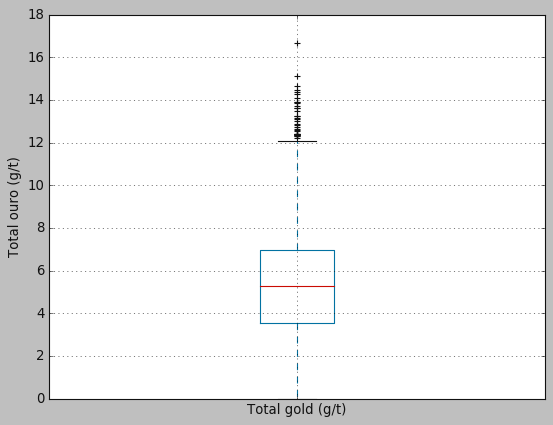

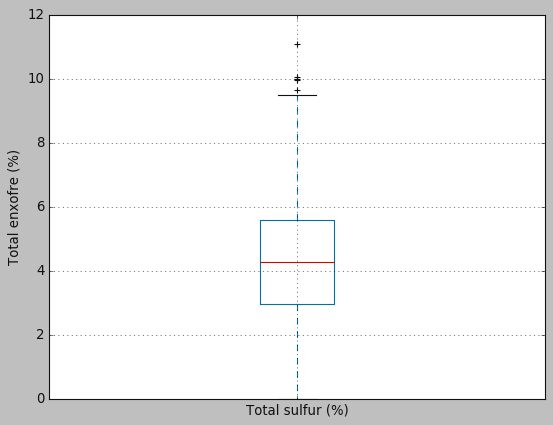

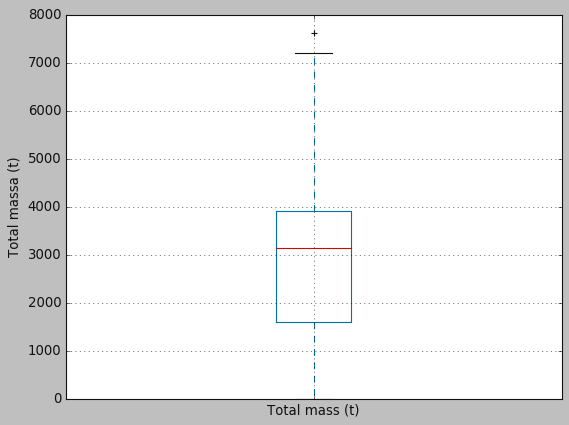

In [5]:
criar_boxplot('Total gold (g/t)', 'Total ouro (g/t)', 'Boxplot_gold.png')
criar_boxplot('Total sulfur (%)', 'Total enxofre (%)', 'Boxplot_enxofre.png')
criar_boxplot('Total mass (t)', 'Total massa (t)', 'Boxplot_massa.png')

<h3> 1.5 Download das variáveis de condicionamento dos tanques </h3> 

In [6]:
ENDERECO_ARQUIVO =  'D://Drive//AGA - GEOMET//AVALIAÇÃO//1- ANÁLISE EXPLORATÓRIA//DATA//'
DF_DADOS_COND_TANQUES = pd.read_excel(ENDERECO_ARQUIVO  + 'Condicionamento.xlsx', index_col='Data')
df = pd.concat([df,DF_DADOS_COND_TANQUES ], join='inner', axis=1)
df.describe()
display(df)

,Identificação,CUIABA - BAL-Au (g/t),CUIABA - BAL-Massa (t),CUIABA - BAL-S (%),CUIABA - CGA-Au (g/t),CUIABA - CGA-Massa (t),CUIABA - CGA-S (%),CUIABA - FGS-Au (g/t),CUIABA - FGS-Massa (t),CUIABA - FGS-S (%),CUIABA - GAL-Au (g/t),CUIABA - GAL-Massa (t),CUIABA - GAL-S (%),CUIABA - GFW-Au (g/t),CUIABA - GFW-Massa (t),CUIABA - GFW-S (%),CUIABA - LIG-Au (g/t),CUIABA - LIG-Massa (t),CUIABA - LIG-S (%),CUIABA - SER-Au (g/t),CUIABA - SER-Massa (t),CUIABA - SER-S (%),CUIABA - VQZ-Au (g/t),CUIABA - VQZ-Massa (t),CUIABA - VQZ-S (%),LAMEGO - ARA-Au (g/t),LAMEGO - ARA-Massa (t),LAMEGO - ARA-S (%),LAMEGO - ARC-Au (g/t),LAMEGO - ARC-Massa (t),LAMEGO - ARC-S (%),LAMEGO - ARD-Au (g/t),LAMEGO - ARD-Massa (t),LAMEGO - ARD-S (%),LAMEGO - ARS-Au (g/t),LAMEGO - ARS-Massa (t),LAMEGO - ARS-S (%),LAMEGO - ARV-Au (g/t),LAMEGO - ARV-Massa (t),LAMEGO - ARV-S (%),LAMEGO - ARV2-Au (g/t),LAMEGO - ARV2-Massa (t),LAMEGO - ARV2-S (%),LAMEGO - CAR-Au (g/t),LAMEGO - CAR-Massa (t),LAMEGO - CAR-S (%),LAMEGO - DAS-Au (g/t),LAMEGO - DAS-Massa (t),LAMEGO - DAS-S (%),LAMEGO - DSC-Au (g/t),LAMEGO - DSC-Massa (t),LAMEGO - DSC-S (%),LAMEGO - DSQ-Au (g/t),LAMEGO - DSQ-Massa (t),LAMEGO - DSQ-S (%),LAMEGO - MD-Au (g/t),LAMEGO - MD-Massa (t),LAMEGO - MD-S (%),LAMEGO - QMD-Au (g/t),LAMEGO - QMD-Massa (t),LAMEGO - QMD-S (%),LAMEGO - V-Au (g/t),LAMEGO - V-Massa (t),LAMEGO - V-S (%),Total gold (g/t),Total sulfur (%),Total mass (t),Código,Tonelagem tratada úmida (Turno A),Tonelagem tratada úmida (Turno B),Tonelagem tratada úmida (Turno C),Tonelagem tratada úmida (diário),percentual de umidade (Turno A),teor Au (g/ton) (Turno A),teor S (%) (Turno A),percentual de umidade (Turno B),teor Au (g/ton) (Turno B),teor S (%) (Turno B),percentual de umidade (Turno C),teor Au (g/ton) (Turno C),teor S (%) (Turno C),Tonelagem seca (Turno A),Tonelagem seca (Turno B),Tonelagem seca (Turno C)
Data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-02-14,1,7.653,1873.584,9.997,0.0,0.0,0.0,0.000,0.000,0.000,4.115,2430.160,5.038,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,5.655226,7.196842,4303.744,410,1820.0,1716.0,1775.0,5311.0,2.22,4.17,4.06,2.67,3.92,3.41,2.42,4.16,3.17,1779.5960,1670.1828,1732.0450
2016-02-15,2,3.784,874.613,5.647,0.0,0.0,0.0,0.000,0.000,0.000,3.880,2539.455,4.883,0.0,0.0,0.0,0.0,0.0,0.0,4.650,140.641,3.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,3.886845,5.014281,3554.709,411,1819.0,1782.0,1807.0,5408.0,2.35,7.00,7.31,2.23,4.54,4.04,2.38,3.56,3.18,1776.2535,1742.2614,1763.9934
2016-02-16,3,3.059,2135.147,3.888,0.0,0.0,0.0,5.782,507.270,4.751,3.900,700.955,4.990,0.0,0.0,0.0,0.0,0.0,0.0,4.650,479.601,3.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,3.774110,4.149619,3822.973,412,1823.0,1733.0,1832.0,5388.0,2.64,3.30,3.69,2.72,3.35,3.85,2.21,3.10,3.82,1774.8728,1685.8624,1791.5128
2016-02-17,4,2.810,721.538,4.560,0.0,0.0,0.0,6.048,601.281,3.335,4.757,2039.346,5.160,0.0,0.0,0.0,0.0,0.0,0.0,4.650,240.513,3.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,4.575381,4.621085,3602.678,413,1627.0,1681.0,1761.0,5069.0,2.66,3.41,4.67,2.46,2.85,4.37,2.59,2.71,5.04,1583.7218,1639.6474,1715.3901
2016-02-18,5,2.859,1391.001,3.614,0.0,0.0,0.0,5.000,556.401,3.250,3.227,963.765,3.224,0.0,0.0,0.0,0.0,0.0,0.0,8.221,1241.965,4.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,

<h3> 1.5 Download das variáveis de saída do modelo </h3> 

,Identificação,CUIABA - BAL-Au (g/t),CUIABA - BAL-Massa (t),CUIABA - BAL-S (%),CUIABA - CGA-Au (g/t),CUIABA - CGA-Massa (t),CUIABA - CGA-S (%),CUIABA - FGS-Au (g/t),CUIABA - FGS-Massa (t),CUIABA - FGS-S (%),CUIABA - GAL-Au (g/t),CUIABA - GAL-Massa (t),CUIABA - GAL-S (%),CUIABA - GFW-Au (g/t),CUIABA - GFW-Massa (t),CUIABA - GFW-S (%),CUIABA - LIG-Au (g/t),CUIABA - LIG-Massa (t),CUIABA - LIG-S (%),CUIABA - SER-Au (g/t),CUIABA - SER-Massa (t),CUIABA - SER-S (%),CUIABA - VQZ-Au (g/t),CUIABA - VQZ-Massa (t),CUIABA - VQZ-S (%),LAMEGO - ARA-Au (g/t),LAMEGO - ARA-Massa (t),LAMEGO - ARA-S (%),LAMEGO - ARC-Au (g/t),LAMEGO - ARC-Massa (t),LAMEGO - ARC-S (%),LAMEGO - ARD-Au (g/t),LAMEGO - ARD-Massa (t),LAMEGO - ARD-S (%),LAMEGO - ARS-Au (g/t),LAMEGO - ARS-Massa (t),LAMEGO - ARS-S (%),LAMEGO - ARV-Au (g/t),LAMEGO - ARV-Massa (t),LAMEGO - ARV-S (%),LAMEGO - ARV2-Au (g/t),LAMEGO - ARV2-Massa (t),LAMEGO - ARV2-S (%),LAMEGO - CAR-Au (g/t),LAMEGO - CAR-Massa (t),LAMEGO - CAR-S (%),LAMEGO - DAS-Au (g/t),LAMEGO - DAS-Massa (t),LAMEGO - DAS-S (%),LAMEGO - DSC-Au (g/t),LAMEGO - DSC-Massa (t),LAMEGO - DSC-S (%),LAMEGO - DSQ-Au (g/t),LAMEGO - DSQ-Massa (t),LAMEGO - DSQ-S (%),LAMEGO - MD-Au (g/t),LAMEGO - MD-Massa (t),LAMEGO - MD-S (%),LAMEGO - QMD-Au (g/t),LAMEGO - QMD-Massa (t),LAMEGO - QMD-S (%),LAMEGO - V-Au (g/t),LAMEGO - V-Massa (t),LAMEGO - V-S (%),Total gold (g/t),Total sulfur (%),Total mass (t),Código,Tonelagem tratada úmida (Turno A),Tonelagem tratada úmida (Turno B),Tonelagem tratada úmida (Turno C),Tonelagem tratada úmida (diário),percentual de umidade (Turno A),teor Au (g/ton) (Turno A),teor S (%) (Turno A),percentual de umidade (Turno B),teor Au (g/ton) (Turno B),teor S (%) (Turno B),percentual de umidade (Turno C),teor Au (g/ton) (Turno C),teor S (%) (Turno C),Tonelagem seca (Turno A),Tonelagem seca (Turno B),Tonelagem seca (Turno C),Código,Ouro Alimentação (g),Ouro Real (g),Rec Au Flot (%),Rec Au Lix (%),Rec Au Grav (%),Rec Au (%),Ouro real gravimetria (g),Ouro Real Flotação (g),Ouro Real Lixiviação (g)
Data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-02-14,1,7.653,1873.584,9.997,0.0,0.0,0.0,0.000,0.000,0.000,4.115,2430.160,5.038,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.655226,7.196842,4303.744,410,1820.0,1716.0,1775.0,5311.0,2.22,4.17,4.06,2.67,3.92,3.41,2.42,4.16,3.17,1779.5960,1670.1828,1732.0450,410.0,17058.408960,20725.065431,94.456597,95.826995,33.005923,92.867556,6988.456044,10719.203008,612.310000
2016-02-15,2,3.784,874.613,5.647,0.0,0.0,0.0,0.000,0.000,0.000,3.880,2539.455,4.883,0.0,0.0,0.0,0.0,0.0,0.0,4.650,140.641,3.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.886845,5.014281,3554.709,411,1819.0,1782.0,1807.0,5408.0,2.35,7.00,7.31,2.23,4.54,4.04,2.38,3.56,3.18,1776.2535,1742.2614,1763.9934,411.0,14722.193599,17229.153695,94.853900,95.501649,28.947434,93.737582,7706.807813,22537.551593,675.490000
2016-02-16,3,3.059,2135.147,3.888,0.0,0.0,0.0,5.782,507.270,4.751,3.900,700.955,4.990,0.0,0.0,0.0,0.0,0.0,0.0,4.650,479.601,3.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.774110,4.149619,3822.973,412,1823.0,1733.0,1832.0,5388.0,2.64,3.30,3.69,2.72,3.35,3.85,2.21,3.10,3.82,1774.8728,1685.8624,1791.5128,412.0,28862.746290,21750.962652,94.738223,95.402483,45.731993,93.520760,7801.150331,14599.399150,769.920000
2016-02-17,4,2.810,721.538,4.560,0.0,0.0,0.0,6.048,601.281,3.335,4.757,2039.346,5.160,0.0,0.0,0.0,0.0,0.0,0.0,4.650,240.513,3.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

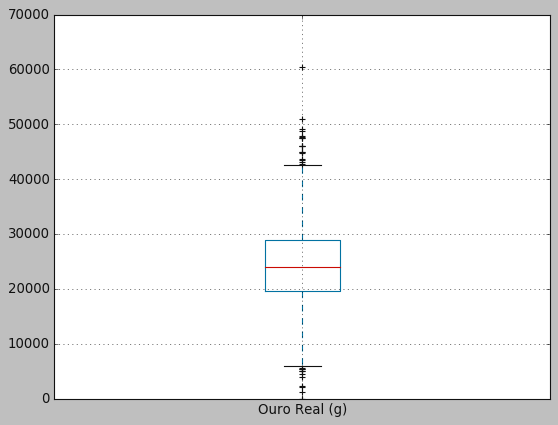

In [7]:
ENDERECO_ARQUIVO  =  'D://Drive//AGA - GEOMET//AVALIAÇÃO//1- ANÁLISE EXPLORATÓRIA//DATA//'
DF_DADOS_RESPOSTA = pd.read_excel(ENDERECO_ARQUIVO  + 'Global.xlsx', index_col='Data').dropna()
df = pd.concat([df, DF_DADOS_RESPOSTA], join = 'inner', axis=1 )
df.describe()
display(df)

DF_DADOS_RESPOSTA[['Ouro Real (g)']].boxplot()



<h2> 2 -  Feature engineering  </h2> 

<h3> 2.1 Filtragem de valores extremos </h3> 

In [8]:
DADOS_FILTRADOS = df[df['Rec Au (%)']> 87]
DADOS_FILTRADOS = DADOS_FILTRADOS[DADOS_FILTRADOS['Ouro Alimentação (g)']> 0]
DADOS_FILTRADOS = DADOS_FILTRADOS[DADOS_FILTRADOS['Total mass (t)']< 7000]
DADOS_FILTRADOS = DADOS_FILTRADOS[DADOS_FILTRADOS['Total mass (t)']> 1000]
DADOS_FILTRADOS = DADOS_FILTRADOS[DADOS_FILTRADOS['Total gold (g/t)']< 12.5]
DADOS_FILTRADOS = DADOS_FILTRADOS[DADOS_FILTRADOS['Total gold (g/t)']> 2.5]
DADOS_FILTRADOS = DADOS_FILTRADOS[DADOS_FILTRADOS['Tonelagem seca (Turno A)']> 0]
DADOS_FILTRADOS = DADOS_FILTRADOS[DADOS_FILTRADOS['Tonelagem seca (Turno B)']> 0]
DADOS_FILTRADOS = DADOS_FILTRADOS[DADOS_FILTRADOS['Tonelagem seca (Turno C)']> 0]
DADOS_FILTRADOS.describe()

,Identificação,CUIABA - BAL-Au (g/t),CUIABA - BAL-Massa (t),CUIABA - BAL-S (%),CUIABA - CGA-Au (g/t),CUIABA - CGA-Massa (t),CUIABA - CGA-S (%),CUIABA - FGS-Au (g/t),CUIABA - FGS-Massa (t),CUIABA - FGS-S (%),CUIABA - GAL-Au (g/t),CUIABA - GAL-Massa (t),CUIABA - GAL-S (%),CUIABA - GFW-Au (g/t),CUIABA - GFW-Massa (t),CUIABA - GFW-S (%),CUIABA - LIG-Au (g/t),CUIABA - LIG-Massa (t),CUIABA - LIG-S (%),CUIABA - SER-Au (g/t),CUIABA - SER-Massa (t),CUIABA - SER-S (%),CUIABA - VQZ-Au (g/t),CUIABA - VQZ-Massa (t),CUIABA - VQZ-S (%),LAMEGO - ARA-Au (g/t),LAMEGO - ARA-Massa (t),LAMEGO - ARA-S (%),LAMEGO - ARC-Au (g/t),LAMEGO - ARC-Massa (t),LAMEGO - ARC-S (%),LAMEGO - ARD-Au (g/t),LAMEGO - ARD-Massa (t),LAMEGO - ARD-S (%),LAMEGO - ARS-Au (g/t),LAMEGO - ARS-Massa (t),LAMEGO - ARS-S (%),LAMEGO - ARV-Au (g/t),LAMEGO - ARV-Massa (t),LAMEGO - ARV-S (%),LAMEGO - ARV2-Au (g/t),LAMEGO - ARV2-Massa (t),LAMEGO - ARV2-S (%),LAMEGO - CAR-Au (g/t),LAMEGO - CAR-Massa (t),LAMEGO - CAR-S (%),LAMEGO - DAS-Au (g/t),LAMEGO - DAS-Massa (t),LAMEGO - DAS-S (%),LAMEGO - DSC-Au (g/t),LAMEGO - DSC-Massa (t),LAMEGO - DSC-S (%),LAMEGO - DSQ-Au (g/t),LAMEGO - DSQ-Massa (t),LAMEGO - DSQ-S (%),LAMEGO - MD-Au (g/t),LAMEGO - MD-Massa (t),LAMEGO - MD-S (%),LAMEGO - QMD-Au (g/t),LAMEGO - QMD-Massa (t),LAMEGO - QMD-S (%),LAMEGO - V-Au (g/t),LAMEGO - V-Massa (t),LAMEGO - V-S (%),Total gold (g/t),Total sulfur (%),Total mass (t),Código,Tonelagem tratada úmida (Turno A),Tonelagem tratada úmida (Turno B),Tonelagem tratada úmida (Turno C),Tonelagem tratada úmida (diário),percentual de umidade (Turno A),teor Au (g/ton) (Turno A),teor S (%) (Turno A),percentual de umidade (Turno B),teor Au (g/ton) (Turno B),teor S (%) (Turno B),percentual de umidade (Turno C),teor Au (g/ton) (Turno C),teor S (%) (Turno C),Tonelagem seca (Turno A),Tonelagem seca (Turno B),Tonelagem seca (Turno C),Código,Ouro Alimentação (g),Ouro Real (g),Rec Au Flot (%),Rec Au Lix (%),Rec Au Grav (%),Rec Au (%),Ouro real gravimetria (g),Ouro Real Flotação (g),Ouro Real Lixiviação (g)
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.0,1258.0,1258.0,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.00000,1258.000000,1258.000000,1258.000000,1257.000000,1258.000000,1258.000000,1256.000000,1258.000000,1258.000000,1253.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,692.494436,3.643005,754.366146,3.533533,0.845387,127.534014,0.958188,4.983975,965.798839,3.423990,3.600052,551.294348,3.533769,0.185605,8.380736,0.138336,0.020986,1.247984,0.013871,4.953637,480.125479,3.103767,0.076707,6.474388,0.034533,0.003267,0.103937,0.000612,0.073227,11.046773,0.021057,0.014030,2.987521,0.007901,0.054285,11.858263,0.035310,0.361145,92.835068,0.472959,0.0,0.0,0.0,0.699700,155.973756,0.345714,0.012011,2.090192,0.020564,0.010382,1.225635,0.010008,0.046113,2.280564,0.022345,0.020890,1.097564,0.014523,0.229714,32.686737,0.167241,0.012997,3.725638,0.021828,5.875098,4.548414,3213.133584,1055.480127,1718.75303,1618.566491,1690.045016,5027.245300,2.578891,5.358345,4.502895,2.580323,5.425589,4.488618,2.597213,5.315561,4.430536,1673.912540,1576.091173,1645.778981,1055.480127,26017.756816,24003.528559,95.151833,94.692575,31.4

<h3> 2.2 Visualização da série temporal de produção do ouro </h3> 

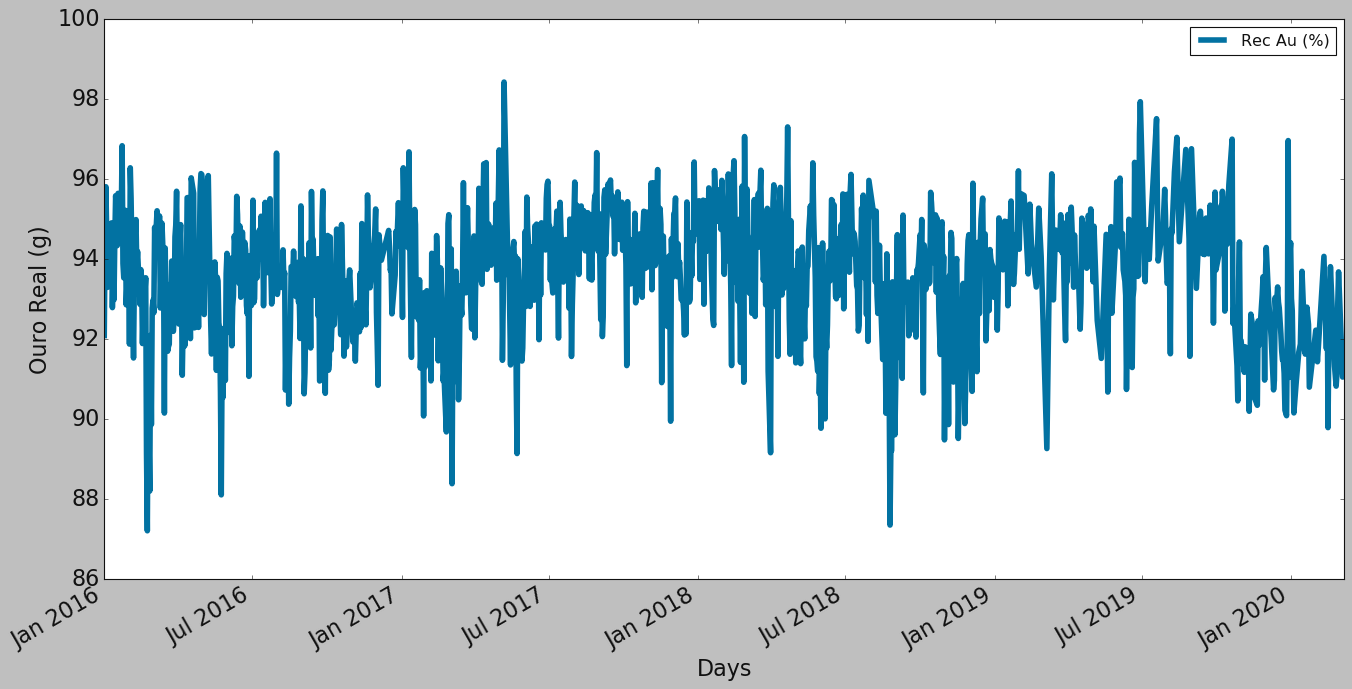

In [9]:
DADOS_FILTRADOS[['Rec Au (%)']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Days', fontsize=20)
plt.ylabel('Ouro Real (g)', fontsize=20)
plt.savefig('./plots/decompose_ouro_total.png', dpi =300, facecolor='whitesmoke')
plt.show()

<h3> 2.3 Análise tendência dos processos </h3> 

In [10]:
DADOS_FILTRADOS = DADOS_FILTRADOS.loc[:,~DADOS_FILTRADOS.columns.duplicated()]  # remova colunas duplicadas acidentalmente
DADOS_FILTRADOS.index = pd.to_datetime(DADOS_FILTRADOS.index)
DADOS_FILTRADOS = DADOS_FILTRADOS.resample(JANELA_TEMPORAL, closed= 'left').mean()               # realizar medidas no suporte temporal desejado
DADOS_FILTRADOS = DADOS_FILTRADOS.dropna()

DECOMPOSTOS_GLOBAL = decomposicao_series_temporais(DADOS_FILTRADOS,'Rec Au (%)',  "tgold.xlsx", "flot_globtest.txt")          # Análise ouro global
DECOMPOSTOS_FLOTAÇÃO = decomposicao_series_temporais(DADOS_FILTRADOS,'Rec Au Flot (%)',  "flot_gold.xlsx", "flot_ftest.txt")       # Análise flotação
DECOMPOSTOS_LIXIVIAÇÃO=  decomposicao_series_temporais(DADOS_FILTRADOS,'Rec Au Lix (%)',  "lix_gold.xlsx", "flot_lixtest.txt")        # Análise lixiviação  
DECOMPOSTOS_GRAVIMETRIA = decomposicao_series_temporais(DADOS_FILTRADOS,'Rec Au Lix (%)',  "grav_gold.xlsx", "flot_gravtest.txt")     # Análise gravimetria



DADOS_FILTRADOS.drop(DADOS_FILTRADOS.head(TEMPO_RESIDENCIA).index,inplace=True)     # considere o tempo de residência
DECOMPOSTOS_GLOBAL.drop( DECOMPOSTOS_GLOBAL.head(TEMPO_RESIDENCIA).index,inplace=True)     # considere o tempo de residência


DADOS_FILTRADOS.index = DECOMPOSTOS_GLOBAL.index  # FORCE A EQUIVALENCIA DE INDEX




CONCAT = DADOS_FILTRADOS.join(DECOMPOSTOS_GLOBAL , how='outer').dropna()
#CONCAT = pd.concat([DADOS_FILTRADOS,DECOMPOSTOS_GLOBAL ], axis = 1)
display(CONCAT.dropna())

#DECOMPOSTOS_GLOBAL = DECOMPOSTOS_GLOBAL.set_index('Data') -> apenas adicionar se análise diária
#DADOS_FILTRADOS = DADOS_FILTRADOS.set_index('Data')



ValueError: x must have 2 complete cycles requires 60 observations. x only has 51 observation(s)

<h3> 2.4 Verificação resíduos </h3> 

In [ ]:
from scipy.stats import norm
plt.hist(CONCAT['residual'].values, bins= 16, density= True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, CONCAT['residual'].mean(), CONCAT['residual'].std())
plt.plot(x, y)
plt.show()
print(CONCAT['residual'].mean())
print(CONCAT['residual'].std())

<h3> 2.5 Determinação dos dados de treinamento </h3> 

In [ ]:

OUTPUTS = CONCAT['Tendencia']





INPUTS =  CONCAT.drop(['Data', 'sazonal', 'residual', 'Tendencia', 'Identificação',  'Código','Ouro Real (g)',
                          'Ouro real gravimetria (g)','Ouro Real Flotação (g)', 'Ouro Real Lixiviação (g)',
                        'Rec Au Flot (%)', 'Rec Au Grav (%)', 'Rec Au Lix (%)', 'Ouro Alimentação (g)',
                         'Rec Au (%)'], axis =1)
COLUNAS_SETORES = COLUNAS_VARIAVEIS_QUIMICAS.drop(['Identificação' ,'Total mass (t)', 'Total gold (g/t)', 'Total sulfur (%)'])





DATAS_OUTPUTS = CONCAT['Data']


display(INPUTS)
display(OUTPUTS)



<h3> 2.6 Seleção de variáveis mais importantes </h3> 

In [ ]:
selecionar_variaveis_importantes(DADOS_FILTRADOS[COLUNAS_SETORES],DADOS_FILTRADOS['Ouro Real (g)'], 'ouro_real' )
selecionar_variaveis_importantes(DADOS_FILTRADOS[COLUNAS_SETORES],DADOS_FILTRADOS['Rec Au Flot (%)'], 'stopes_flot' )
selecionar_variaveis_importantes(DADOS_FILTRADOS[COLUNAS_SETORES],DADOS_FILTRADOS['Rec Au Grav (%)'], 'stopes_grav' )
selecionar_variaveis_importantes(DADOS_FILTRADOS[COLUNAS_SETORES],DADOS_FILTRADOS['Rec Au Lix (%)'], 'stopes_lix' )



<h3> 2.6 Correlação variáveis </h3> 

In [ ]:
plt.figure(figsize =(20,20))
VIZUALIZADOR = Rank2D(algorithm='covariance', features = INPUTS.columns)
VIZUALIZADOR.fit(INPUTS,OUTPUTS)          
VIZUALIZADOR.transform(INPUTS)            
VIZUALIZADOR.show()                     

<h3> 2.8 Contaminação dos dados </h3> 

In [ ]:
COMPONENTES_PRINCIPAIS = PCA(n_components=2, svd_solver='full') # modelar PCA de duas variáveis
COMPONENTES_PRINCIPAIS = COMPONENTES_PRINCIPAIS.fit_transform(INPUTS)
INPUTS_TREINO, INPUTS_TESTE,  OUTPUTS_TREINO, OUTPUT_TESTES = train_test_split(COMPONENTES_PRINCIPAIS, OUTPUTS) 

clf = IForest(contamination = 0.05)
clf.fit(INPUTS_TREINO)

ROTULOS_PREDITORES_TREINO = clf.labels_  
SCORES_PREDITORES_TREINO = clf.decision_scores_  
ROTULOS_PREDITORES_TESTE = clf.predict(INPUTS_TESTE)  # outlier labels (0 or 1)
SCORES_PREDITORES_TESTE = clf.decision_function(INPUTS_TESTE)  # outlier scores


DATAFRAME_PLOTAGEM = pd.DataFrame(np.array([INPUTS_TREINO[:,0], 
                                INPUTS_TREINO[:,1],
                                SCORES_PREDITORES_TREINO ]).T, 
                      columns= ['PCA 1', 'PCA 2', 'In-outliers'])

ax = sns.scatterplot(x='PCA 1', y= 'PCA 2',
                     hue='In-outliers', data=DATAFRAME_PLOTAGEM)

plt.savefig('./plots/contaminacao.png', facecolor='whitesmoke')

<h3> 2.9 Transformação dos dados </h3> 

In [ ]:
#TRANSFORMADA = quantile_transform(INPUTS, output_distribution = 'normal')
TRANSFORMADA = INPUTS

<h3> 2.9 Análise de padrões </h3> 

In [ ]:
COMPONENTES_PRINCIPAIS = PCA(n_components=3, svd_solver='full')
print(np.cumsum(COMPONENTES_PRINCIPAIS.fit(TRANSFORMADA).explained_variance_ratio_))
COMPONENTES_PRINCIPAIS = COMPONENTES_PRINCIPAIS.fit_transform(TRANSFORMADA)


DATAFRAME_PLOTAGEM = pd.DataFrame(np.array([COMPONENTES_PRINCIPAIS[:,0], 
                                            COMPONENTES_PRINCIPAIS[:,1], 
                                            COMPONENTES_PRINCIPAIS[:,2], 
                                            OUTPUTS]).T, 
                                  columns= ['PCA 1', 'PCA 2', 'PCA 3','Rec Au (%)'])

fig = go.Figure(data=[go.Scatter3d(
    x=DATAFRAME_PLOTAGEM['PCA 1'] ,
    y=DATAFRAME_PLOTAGEM['PCA 2'] ,
    z=DATAFRAME_PLOTAGEM['PCA 3'] ,
    mode='markers',
    marker=dict(
        size=3,
        color=DATAFRAME_PLOTAGEM['Rec Au (%)'],                
        colorscale='Viridis',   
        colorbar=dict(thickness=20),
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
COMPONENTES_PRINCIPAIS = PCA(n_components=5, svd_solver='full').fit_transform(TRANSFORMADA)
print(np.cumsum(PCA(n_components=5, svd_solver='full').fit(TRANSFORMADA).explained_variance_ratio_))




<h3> 2.10 Exportação de dados </h3> 

In [ ]:

display(OUTPUTS)

ENDERECO_ARQUIVO_SALVAMENTO = 'D:/Drive/AGA - GEOMET/AVALIAÇÃO/2- AJUSTAR MODELO/pca_values.sav'
pickle.dump(COMPONENTES_PRINCIPAIS, open(ENDERECO_ARQUIVO_SALVAMENTO, 'wb'))
ENDERECO_ARQUIVO_SALVAMENTO = 'D:/Drive/AGA - GEOMET/AVALIAÇÃO/2- AJUSTAR MODELO/reponses.sav'
pickle.dump(OUTPUTS, open(ENDERECO_ARQUIVO_SALVAMENTO, 'wb'))
df = pd.DataFrame(np.array([OUTPUTS, DATAS_OUTPUTS]).T ,  columns =['previsores', 'Data'])
df.to_excel('previsores.xlsx')

display(df.describe())

<h3> 2.10 Salvar dados alimentação dos dados de treino </h3> 

In [ ]:
ENDERECO_ARQUIVO_SALVAMENTO = 'D:/Drive/AGA - GEOMET/AVALIAÇÃO/2- AJUSTAR MODELO/alimentacao.sav'
pickle.dump(CONCAT['Rec Au (%)'], open(ENDERECO_ARQUIVO_SALVAMENTO, 'wb'))
